In [1]:
import os
import json
import math

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from matplotlib import ticker
from keras import layers, optimizers
from keras import Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.models import Sequential

from imgaug import augmenters as iaa
from keras.utils import Sequence
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score




Using TensorFlow backend.


In [2]:
print(os.listdir("../input"))

path_train_img   = "../input/aptos2019-blindness-detection/train_images" 
path_train_excel = "../input/aptos2019-blindness-detection/train.csv" 
test_csv = "../input/aptos2019-blindness-detection/test.csv" 

df_train = pd.read_csv(path_train_excel)

sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')    
# if sub.shape[0] < 2000:
#     sub['diagnosis'] = -1
#     sub.to_csv('submission.csv',index=False)
#     del df_train

image_size = 224

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5),
        ])
    ),
    iaa.Fliplr(0.5),
    sometimes(
        iaa.OneOf([
            iaa.Affine(
                scale={"x": (0.9, 1.25), "y": (0.9, 1.1)},
            ),
            iaa.Crop(percent=(0, 0.15))
        ])
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-6, 6)
    )
    
],random_order=True)

seq_test = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5),
        ])
    ),
    sometimes(
        iaa.OneOf([
            iaa.Crop(percent=(0, 0.15))
        ])
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-8, 8)
    )
    
],random_order=True)

def autocrop(image, threshold=10):
    if len(image.shape) == 3:
        flatimage = np.max(image, 2)
    else:
        flatIimage = image
    assert len(flatimage.shape) == 2

    rows = np.where(np.max(flatimage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatimage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]
        
    return image

['kerneldacb007d25', 'resnet50', 'aptos2019-blindness-detection']


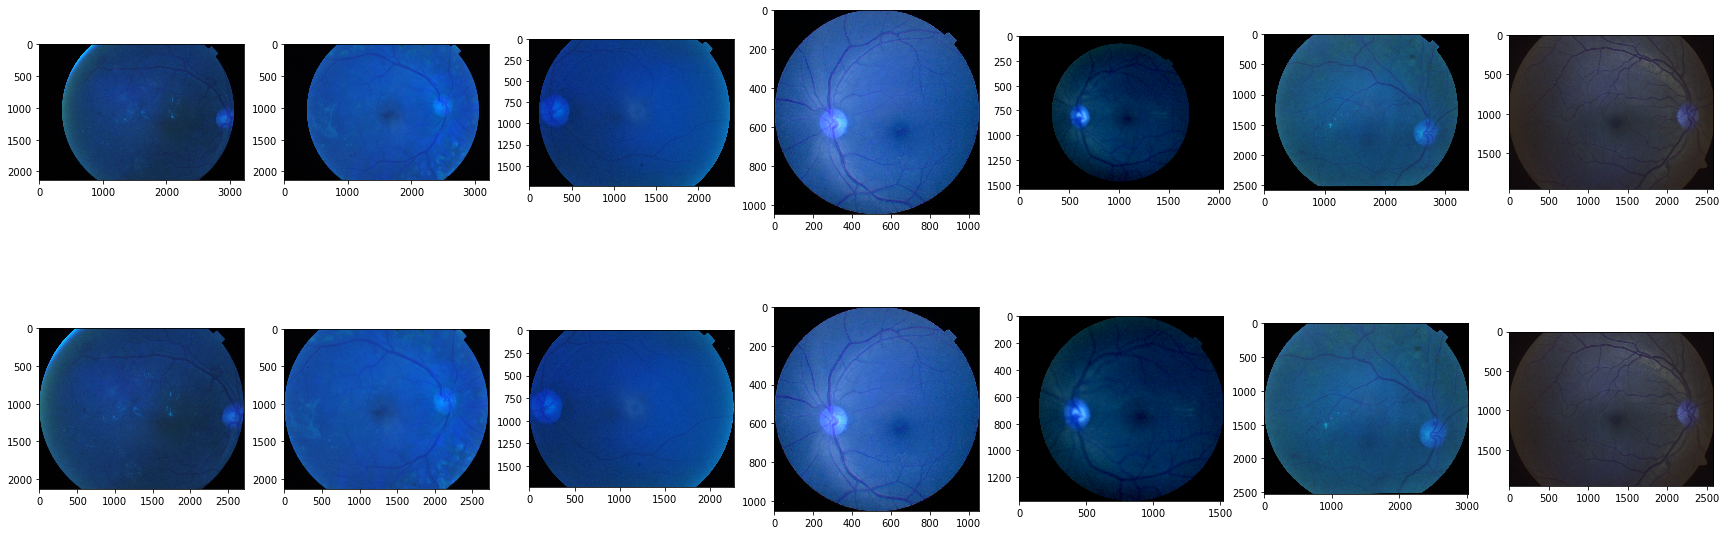

In [3]:
fig,ax = plt.subplots(2,7,figsize=(30,10))
for it,ID in enumerate(df_train["id_code"][0:7]):
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/{}.png".format(ID))          
    cropped = autocrop(img, threshold=12)
    ax[0][it].imshow(img)
    ax[1][it].imshow(cropped)

In [4]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=5, shuffle=True,augment=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        IDs = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]
        labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(IDs,labels)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp,list_y_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
    
        # Generate data
        for i, (ID,label) in enumerate(zip(list_IDs_temp,list_y_temp)):
           
            img = cv2.imread("../input/aptos2019-blindness-detection/train_images/{}.png".format(ID))
#             cropped = autocrop(img, threshold=12)
            img = cv2.resize(img, self.dim)
            kernel_size = 5
            blurr = cv2.blur(img,(kernel_size,kernel_size))
            img = cv2.addWeighted(img,4,blurr,-4 ,128)

            if self.augment:
               img = seq.augment_image(img)
            X[i,] = img
            # Store class
            y[i] = label
        
        return X/255.,to_categorical(y, num_classes=self.n_classes, dtype='int8')
    
#define train and validation generator
# X_train,X_val,y_train,y_val = train_test_split(df_train["id_code"],df_train["diagnosis"] , shuffle=True)
skf = StratifiedKFold(n_splits=10)
train_index, test_index = next(skf.split(df_train["id_code"],df_train["diagnosis"]))
X_train,X_val = df_train["id_code"].iloc[train_index], df_train["id_code"].iloc[test_index]
y_train,y_val = df_train["diagnosis"][train_index], df_train["diagnosis"][test_index]

train_gen = DataGenerator(X_train,y_train,n_classes=y_train.unique().shape[0],batch_size=32,augment=True)
valid_gen = DataGenerator(X_val, y_val,n_classes=y_train.unique().shape[0],augment=False)
valid_gen_aug = DataGenerator(X_val, y_val,n_classes=y_train.unique().shape[0],augment=True)


In [5]:
inp = layers.Input(shape=(image_size, image_size, 3), name='image_input')
base_model = ResNet50(include_top=False,
                   weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',input_tensor=inp)
# base_model = ResNet50(include_top=False,
#                    weights=None,input_tensor=inp)


x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(2048,activation='relu')(x) 
x = layers.Dropout(0.4)(x)
x = layers.Dense(2048,activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=inp, outputs=x)
model.load_weights('../input/kerneldacb007d25/model.h5')

# for layer in base_model.layers:
#     layer.trainable = False
# for layer in model.layers[-26:]:
#     layer.trainable = True
#sanity check trainig layers
for layer in model.layers:
    print("{} is trainable {}".format(layer.name,layer.trainable))
    

model.summary()


# Compile Model

# model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])

# def scheduler(epoch,learning_rate):
#     lr = learning_rate
#     if epoch==3:
#         lr = 7e-5
#     if epoch==6:
#         lr = 4e-5
#     if epoch==9:
#         lr = 1e-5
#     if epoch==12:
#         lr = 8e-6
#     return lr


# checkpoint = ModelCheckpoint('model.h5', save_best_only=True,verbose=1,monitor='val_acc',mode='max')
# learning_scheduler = LearningRateScheduler(scheduler,verbose=1)
# es = EarlyStopping(monitor='val_acc',mode='max', patience=5, verbose=0)
# history = model.fit_generator(train_gen,verbose=1,epochs=20,validation_data=valid_gen, callbacks=[checkpoint,learning_scheduler,es])


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


image_input is trainable False
conv1_pad is trainable True
conv1 is trainable True
bn_conv1 is trainable True
activation_1 is trainable True
pool1_pad is trainable True
max_pooling2d_1 is trainable True
res2a_branch2a is trainable True
bn2a_branch2a is trainable True
activation_2 is trainable True
res2a_branch2b is trainable True
bn2a_branch2b is trainable True
activation_3 is trainable True
res2a_branch2c is trainable True
res2a_branch1 is trainable True
bn2a_branch2c is trainable True
bn2a_branch1 is trainable True
add_1 is trainable True
activation_4 is trainable True
res2b_branch2a is trainable True
bn2b_branch2a is trainable True
activation_5 is trainable True
res2b_branch2b is trainable True
bn2b_branch2b is trainable True
activation_6 is trainable True
res2b_branch2c is trainable True
bn2b_branch2c is trainable True
add_2 is trainable True
activation_7 is trainable True
res2c_branch2a is trainable True
bn2c_branch2a is trainable True
activation_8 is trainable True
res2c_branch2b

In [6]:
# tta_steps = 10
# predictions_val = []

# for i in range(tta_steps):
#     print("validation TTA prediction " + str(i))
#     preds = model.predict_generator(valid_gen_aug)
#     predictions_val.append(preds)
# pred = np.mean(predictions_val, axis=0)
# accuracy_score(y_val[0:704], np.argmax(pred, axis=-1))

In [7]:
path_test_img = "../input/aptos2019-blindness-detection/test_images"
path_test_excel = "../input/aptos2019-blindness-detection/sample_submission.csv"

df_test = pd.read_csv(path_test_excel)
df_test["diagnosis"] = np.random.randint(5, size=df_test.shape[0])

tta_steps = 10

scores_predicted = np.empty([tta_steps,len(df_test),y_train.unique().shape[0]]) 
# model.load_weights('model.h5')
for step in range(tta_steps):
    for i, name in enumerate(df_test['id_code']):
        path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
        image = cv2.imread(path)
#         cropped = autocrop(image, threshold=12)
        image = cv2.resize(image, (image_size,image_size))
        kernel_size = 5
        blurr = cv2.blur(image,(kernel_size,kernel_size))
        image = cv2.addWeighted(image,4,blurr,-4 ,128)

        image = seq_test.augment_image(image)

        score_predict = model.predict((image[np.newaxis])/255)
        scores_predicted[step,i,:] = score_predict
#         label_predict = np.argmax(score_predict)
#         predicted.append(str(label_predict))
        if i%200 == 0:
            print('Numer added: {}/{}'.format(i,df_test['id_code'].size))

Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928


In [8]:
predicted = np.argmax(scores_predicted.mean(axis=0),axis=1)
df_test['diagnosis'] = predicted
df_test.to_csv('submission.csv',index=False)

df_test["diagnosis"].describe()

count    1928.000000
mean        1.722510
std         1.094057
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: diagnosis, dtype: float64